#### Import Libraries

In [583]:
import pandas as pd
import seaborn as sb
import numpy as np
import tensorflow as tf
import re

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, MaxPooling1D, GlobalMaxPooling1D, Conv1D
from keras.layers import SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE


#### Load the fake news dataset

The dataset can be found at: https://www.kaggle.com/datasets/algord/fake-news?resource=download

In [400]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#### Split the dataset

Split the data into 80% training and 20% testing sets

In [406]:
# Get the features and labels
features = df['v2']
labels = df['v1'].map({'ham': 0, 'spam': 1})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1234)

print("Train data size:", X_train.shape, y_train.shape)
print("Test data size: ", X_test.shape, y_test.shape)

Train data size: (4457,) (4457,)
Test data size:  (1115,) (1115,)


#### Distribution

Plot the distribution of spam and non spam messages

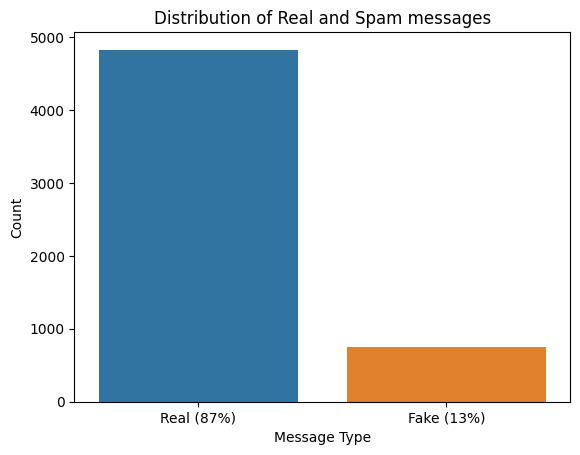

In [459]:
# get the number of spam/ham messages in features
spamPercent = round(len(df[df['v1'] == 'spam']) / df.shape[0] * 100)
realPercent = 100 - spamPercent

plot = sb.countplot(x='v1', data=df)
plot.set_title('Distribution of Real and Spam messages')
plot.set_xlabel('Message Type')
plot.set_ylabel('Count')
plot.set_xticklabels([f'Real ({realPercent}%)', f'Fake ({spamPercent}%)'])
print()

It is a very unbalanced dataset. This will be corrected later on.

#### Dataset Description

- The dataset contains 2 main columns: v1, v2
  - V1: Label (ham: non spam, spam: spam)
  - V2: SMS message
- The model should be able to predict whether a given message is spam or not

#### Preprocess Data

In [396]:
lm = WordNetLemmatizer()
def preProcess(msgs):
  for msg in msgs:
    # Make lowercase
    text = str(msg).lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove stopwords
    # text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    # Lemmatize words
    text = lm.lemmatize(text)

    msgs[msg] = text

  return msgs

In [399]:
# max_features = 2000

# Preprocess the features
X_train = preProcess(X_train)
X_test = preProcess(X_test)

print(X_train.head())

1230    I want to send something that can sell fast.  ...
4224    \The world suffers a lot... Not because of the...
4402                               Just getting back home
1251    Please CALL 08712402779 immediately as there i...
4187    Mm umma ask vava also to come tell him can pla...
Name: v2, dtype: object


#### Text encoding

In [425]:
vocab_size = 10000

Count Vectorization

In [510]:
cv = CountVectorizer(max_features=vocab_size, ngram_range=(1, 2), stop_words='english')
X_train_cv = cv.fit_transform(X_train).toarray()
X_test_cv = cv.transform(X_test).toarray()

print(X_train_cv.shape, X_test_cv.shape)


(4457, 10000) (1115, 10000)


TF-IDF Vectorization

In [511]:
tfidf = TfidfVectorizer(max_features=vocab_size, ngram_range=(1, 2), stop_words='english')
X_train_tf = tfidf.fit_transform(X_train).toarray()
X_test_tf = tfidf.transform(X_test).toarray()

print(X_train_tf.shape, X_test_tf.shape)

(4457, 10000) (1115, 10000)


#### Balance Dataset

The training dataset is imblanced. 

Balance it by synthetically generating more spam messages with SMOTE

In [512]:
sm = SMOTE(random_state=1234)

X_train_cv, y_train_cv = sm.fit_resample(X_train_cv, y_train)
X_train_tf, y_train_tf = sm.fit_resample(X_train_tf, y_train)

In [513]:
spamPercent = round(len(y_train_cv[y_train_cv == 1]) / y_train_cv.shape[0] * 100)
realPercent = 100 - spamPercent

print(f'Real:Spam = {realPercent}:{spamPercent}')

Real:Spam = 50:50


#### Build Models

Fully connected (dense) neural network

In [600]:
fcnn = Sequential()
fcnn.add(Dense(10, input_dim=vocab_size, activation='relu'))
fcnn.add(Dense(1, activation='sigmoid'))
fcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(fcnn.summary())

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_109 (Dense)           (None, 10)                100010    
                                                                 
 dense_110 (Dense)           (None, 1)                 11        
                                                                 
Total params: 100,021
Trainable params: 100,021
Non-trainable params: 0
_________________________________________________________________
None


Recurrent neural network

After trying multiple different RNN models, I could not get one that provided good results within a reasonable amount of time.

As such, I decided to simply ignore using an RNN model for this assignment.

In [ ]:
# RNN
# rnn = Sequential()
# rnn.add(Embedding(vocab_size, 32, input_length=X_train_cv.shape[1]))  
# rnn.add(LSTM(units=32))
# rnn.add(Dense(1, activation='sigmoid'))
# rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# print(rnn.summary())

Convolutional neural network

In [613]:
# CNN
cnn = Sequential()
cnn.add(Conv1D(32, 4, 2, activation='relu', input_shape=(vocab_size, 1)))
cnn.add(MaxPooling1D(2))
cnn.add(Conv1D(16, 2, 1, activation='relu'))
cnn.add(GlobalMaxPooling1D())

cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(cnn.summary())

Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_113 (Conv1D)         (None, 4999, 32)          160       
                                                                 
 max_pooling1d_59 (MaxPoolin  (None, 2499, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_114 (Conv1D)         (None, 2498, 16)          1040      
                                                                 
 global_max_pooling1d_53 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_117 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-train

#### Train Model

In [21]:
train = True

Train the fully connected model

In [619]:
if train:
  fcnn.fit(X_train_cv, y_train_cv, epochs=20, batch_size=128, verbose=2)
  fcnn.save('fcnn_cv')

  fcnn.fit(X_train_tf, y_train_tf, epochs=20, batch_size=128, verbose=2)
  fcnn.save('fcnn_tf')

Epoch 1/20
61/61 - 1s - loss: 0.5984 - accuracy: 0.8199 - 696ms/epoch - 11ms/step
Epoch 2/20
61/61 - 0s - loss: 0.4329 - accuracy: 0.9746 - 339ms/epoch - 6ms/step
Epoch 3/20
61/61 - 0s - loss: 0.3383 - accuracy: 0.9768 - 317ms/epoch - 5ms/step
Epoch 4/20
61/61 - 0s - loss: 0.2766 - accuracy: 0.9730 - 298ms/epoch - 5ms/step
Epoch 5/20
61/61 - 0s - loss: 0.2321 - accuracy: 0.9713 - 310ms/epoch - 5ms/step
Epoch 6/20
61/61 - 0s - loss: 0.1986 - accuracy: 0.9724 - 305ms/epoch - 5ms/step
Epoch 7/20
61/61 - 0s - loss: 0.1729 - accuracy: 0.9710 - 310ms/epoch - 5ms/step
Epoch 8/20
61/61 - 0s - loss: 0.1526 - accuracy: 0.9727 - 322ms/epoch - 5ms/step
Epoch 9/20
61/61 - 0s - loss: 0.1365 - accuracy: 0.9736 - 306ms/epoch - 5ms/step
Epoch 10/20
61/61 - 0s - loss: 0.1233 - accuracy: 0.9746 - 295ms/epoch - 5ms/step
Epoch 11/20
61/61 - 0s - loss: 0.1123 - accuracy: 0.9757 - 289ms/epoch - 5ms/step
Epoch 12/20
61/61 - 0s - loss: 0.1031 - accuracy: 0.9767 - 286ms/epoch - 5ms/step
Epoch 13/20
61/61 - 0s -

INFO:tensorflow:Assets written to: fcnn_cv\assets


Epoch 1/20
61/61 - 0s - loss: 0.0935 - accuracy: 0.9911 - 382ms/epoch - 6ms/step
Epoch 2/20
61/61 - 0s - loss: 0.0508 - accuracy: 0.9937 - 168ms/epoch - 3ms/step
Epoch 3/20
61/61 - 0s - loss: 0.0402 - accuracy: 0.9938 - 159ms/epoch - 3ms/step
Epoch 4/20
61/61 - 0s - loss: 0.0342 - accuracy: 0.9938 - 160ms/epoch - 3ms/step
Epoch 5/20
61/61 - 0s - loss: 0.0301 - accuracy: 0.9938 - 189ms/epoch - 3ms/step
Epoch 6/20
61/61 - 0s - loss: 0.0272 - accuracy: 0.9938 - 167ms/epoch - 3ms/step
Epoch 7/20
61/61 - 0s - loss: 0.0250 - accuracy: 0.9938 - 172ms/epoch - 3ms/step
Epoch 8/20
61/61 - 0s - loss: 0.0232 - accuracy: 0.9938 - 171ms/epoch - 3ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0217 - accuracy: 0.9938 - 160ms/epoch - 3ms/step
Epoch 10/20
61/61 - 0s - loss: 0.0205 - accuracy: 0.9941 - 160ms/epoch - 3ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0194 - accuracy: 0.9942 - 161ms/epoch - 3ms/step
Epoch 12/20
61/61 - 0s - loss: 0.0185 - accuracy: 0.9942 - 160ms/epoch - 3ms/step
Epoch 13/20
61/61 - 0s - 

INFO:tensorflow:Assets written to: fcnn_tf\assets


Train the recurrent model

In [ ]:
# if train:
#   rnn.fit(X_train_cv, y_train_cv, epochs=10, batch_size=32, verbose=2)
#   rnn.save('rnn_cv')
  
#   rnn.fit(X_train_tf, y_train_tf, epochs=10, batch_size=32, verbose=2)
#   rnn.save('rnn_tf')

Train the convolutional model

In [614]:
if train:
  cnn.fit(X_train_tf, y_train_tf, epochs=20, batch_size=128, verbose=2)
  cnn.save('cnn_tf')
  
  cnn.fit(X_train_cv, y_train_cv, epochs=20, batch_size=128, verbose=2)
  cnn.save('cnn_cv')
  

Epoch 1/20
61/61 - 11s - loss: 0.6693 - accuracy: 0.6721 - 11s/epoch - 185ms/step
Epoch 2/20
61/61 - 11s - loss: 0.6119 - accuracy: 0.8250 - 11s/epoch - 176ms/step
Epoch 3/20
61/61 - 11s - loss: 0.5159 - accuracy: 0.8650 - 11s/epoch - 176ms/step
Epoch 4/20
61/61 - 11s - loss: 0.4199 - accuracy: 0.8632 - 11s/epoch - 177ms/step
Epoch 5/20
61/61 - 11s - loss: 0.3667 - accuracy: 0.8632 - 11s/epoch - 177ms/step
Epoch 6/20
61/61 - 11s - loss: 0.3443 - accuracy: 0.8658 - 11s/epoch - 177ms/step
Epoch 7/20
61/61 - 11s - loss: 0.3309 - accuracy: 0.8722 - 11s/epoch - 178ms/step
Epoch 8/20
61/61 - 11s - loss: 0.3230 - accuracy: 0.8742 - 11s/epoch - 177ms/step
Epoch 9/20
61/61 - 11s - loss: 0.3163 - accuracy: 0.8780 - 11s/epoch - 177ms/step
Epoch 10/20
61/61 - 11s - loss: 0.3108 - accuracy: 0.8812 - 11s/epoch - 177ms/step
Epoch 11/20
61/61 - 11s - loss: 0.3058 - accuracy: 0.8821 - 11s/epoch - 176ms/step
Epoch 12/20
61/61 - 11s - loss: 0.3009 - accuracy: 0.8855 - 11s/epoch - 177ms/step
Epoch 13/20
6

INFO:tensorflow:Assets written to: cnn_tf\assets


INFO:tensorflow:Assets written to: cnn_tf\assets


Epoch 1/20
61/61 - 11s - loss: 1.2907 - accuracy: 0.6906 - 11s/epoch - 184ms/step
Epoch 2/20
61/61 - 11s - loss: 0.6043 - accuracy: 0.7478 - 11s/epoch - 180ms/step
Epoch 3/20
61/61 - 11s - loss: 0.5562 - accuracy: 0.7522 - 11s/epoch - 179ms/step
Epoch 4/20
61/61 - 11s - loss: 0.5348 - accuracy: 0.7562 - 11s/epoch - 179ms/step
Epoch 5/20
61/61 - 11s - loss: 0.5201 - accuracy: 0.7675 - 11s/epoch - 179ms/step
Epoch 6/20
61/61 - 11s - loss: 0.5117 - accuracy: 0.7729 - 11s/epoch - 179ms/step
Epoch 7/20
61/61 - 11s - loss: 0.5018 - accuracy: 0.7803 - 11s/epoch - 179ms/step
Epoch 8/20
61/61 - 11s - loss: 0.4957 - accuracy: 0.7850 - 11s/epoch - 180ms/step
Epoch 9/20
61/61 - 11s - loss: 0.4917 - accuracy: 0.7874 - 11s/epoch - 179ms/step
Epoch 10/20
61/61 - 11s - loss: 0.4870 - accuracy: 0.7897 - 11s/epoch - 184ms/step
Epoch 11/20
61/61 - 11s - loss: 0.4826 - accuracy: 0.7892 - 11s/epoch - 182ms/step
Epoch 12/20
61/61 - 11s - loss: 0.4785 - accuracy: 0.7933 - 11s/epoch - 179ms/step
Epoch 13/20
6

INFO:tensorflow:Assets written to: cnn_cv\assets


INFO:tensorflow:Assets written to: cnn_cv\assets


#### Load Models

Load the saved models so that they don't have to be trained again

(If models don't exist, need to set 'train' to true and train the models)

In [620]:
fcnn_cv = tf.keras.models.load_model('fcnn_cv')
fcnn_tf = tf.keras.models.load_model('fcnn_tf')

# rnn_cv = tf.keras.models.load_model('rnn_cv')
# rnn_tf = tf.keras.models.load_model('rnn_tf')

cnn_cv = tf.keras.models.load_model('cnn_cv')
cnn_tf = tf.keras.models.load_model('cnn_tf')

#### Test Model

Run the model on the test set

In [621]:
print("FCNN using TF-IDF")
acc = fcnn.evaluate(X_test_tf, y_test, verbose=0)
print("Accuracy: ", round(acc[1] * 100, 2), "%\n")

print("FCNN using Count Vectorizer")
acc = fcnn.evaluate(X_test_cv, y_test, verbose=0)
print("Accuracy: ", round(acc[1] * 100, 2), "%")

FCNN using TF-IDF
Accuracy:  98.21 %

FCNN using Count Vectorizer
Accuracy:  98.03 %


In [ ]:
# print("RNN using TF-IDF")
# acc = rnn.evaluate(X_test_tf, y_test, verbose=0)
# print("Accuracy: ", round(acc[1] * 100, 2), "%\n")

# print("RNN using Count Vectorizer")
# acc = rnn.evaluate(X_test_cv, y_test, verbose=0)
# print("Accuracy: ", round(acc[1] * 100, 2), "%")

In [617]:
print("CNN using TF-IDF")
acc = cnn_tf.evaluate(X_test_tf, y_test, verbose=0)
print("Accuracy: ", round(acc[1] * 100, 2), "%\n")

print("CNN using Count Vectorizer")
acc = cnn_cv.evaluate(X_test_cv, y_test, verbose=0)
print("Accuracy: ", round(acc[1] * 100, 2), "%")

CNN using TF-IDF
Accuracy:  88.88 %

CNN using Count Vectorizer
Accuracy:  84.3 %


#### Analysis

I attempted to classify the dataset using 2 different models and 2 different embedding approaches for each model.

The first model is a fully connected neural network which first uses a dense layer on the 10000 input values and condenses it down to 10 values. This is then passed to a dense layer with 1 output value. It works surprisingly well and is very fast to train. When vectorizing with TF-IDF it gets an accuracy of 98.2% on the test set and when vectorizing with count it gets an accuracy of 98.0%. Both results are beyond what I expected to achieve. I attempted to modify the model to get better results but it was already performing very well and any modification I made appeared to make it worse.

The second model is a convolutional neural network which first performs a convolutional layer on the 10000 input values with a stride of 2 and then it performs a max pooling layer. It then goes through another convolutional layer and another pooling layer. It then flattens the output and passes it to a dense layer with 1 output value. It works somewhat well but is much slower to train than the fully connected model. When vectorizing with TF-IDF it gets an accuracy of 88.9% on the test set and when vectorizing with count it gets an accuracy of 84.3%. It is slightly worse than the fully connected model but it is still very good. The results are more in line with what I expected to achieve.

I tried to implement a third model using a recurrent neural network but I could not get it to work well. I tried multiple different models but none of them performed well and took quite a long time to train.  I decided to simply ignore using an RNN model for this assignment.

One important note was that the dataset was very imbalanced. There were many more non spam messages than spam messages. This was corrected by using SMOTE to synthetically generate more spam messages which improved the results of the models. Prior to implementing SMOTE, both networks maintained an accuracy around the same as the original distribution which meant that they were simply predicting non spam for every message. With SMOTE, the distribution was balanced at 50% spam and 50% non spam and the models were able to perform more accurately. (actually the CNN performs worse than simply guessing non spam every time lol)

Overall, the fully connected model performed the best and is the one I would recommend using for this dataset. It is quick to train and provides very good results. When comparing the embedding approaches, TF-IDF performed better than count vectorization. This is likely because TF-IDF takes into account the frequency of words in the entire dataset whereas count vectorization only takes into account the frequency of words in the current message. This means that TF-IDF is able to better identify spam messages that use words that are not very common in the dataset.